In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor,RandomForestClassifier
from xgboost import XGBRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

C:\Users\zhang\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
Top200 = pd.read_csv('Top200_Stations.csv',index_col=0)
Top200_test = pd.read_csv('Top200_test_Stations.csv',index_col=0)

In [3]:
Top200.head()

,start_station_latitude,start_station_longitude,start_hour,start_year,start_month,start_day,start_dayofweek,start_station_checkout_counts,start_station_checkin_counts,AWND,...,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,Percent_usage,Isweekday,holidays,Commute,cluster
0,40.751873,-73.977706,18,2017,1,19,4,92.0,72.0,3.58,...,0.0,44.0,0,0,61.0,2.688525,1,0,1,3.0
2,40.722174,-73.983688,8,2017,1,4,3,17.0,3.0,8.05,...,1.0,43.0,0,0,37.0,0.540541,1,0,1,1.0
3,40.732233,-73.988900,20,2017,1,13,5,6.0,4.0,7.16,...,0.0,47.0,0,0,35.0,0.285714,1,0,0,1.0
4,40.755942,-74.002116,18,2017,1,25,3,8.0,3.0,6.71,...,0.0,43.5,0,0,39.0,0.282051,1,0,1,3.0
5,40.730473,-73.986724,6,2017,1,25,3,5.0,1.0,6.71,...,0.0,43.5,0,0,39.0,0.153846,1,0,0,1.0


## Linear Model: Lasso

### Dummification for Linear Model

In [4]:
columns = ['start_hour','start_year','start_month','start_dayofweek','cluster']
Top200_dummified = pd.get_dummies(Top200, columns=columns, prefix=columns, prefix_sep='_',drop_first=True)
Top200_test_dummified = pd.get_dummies(Top200_test, columns=columns, prefix=columns, prefix_sep='_',drop_first=True)

In [5]:
X = Top200_dummified.drop(['start_station_checkout_counts','start_day',\
                           'start_station_checkin_counts','Percent_usage'],axis = 1)
Y = Top200_dummified.start_station_checkout_counts

In [6]:
test_X = Top200_test_dummified.drop(['start_station_checkout_counts','start_day',\
                           'start_station_checkin_counts','Percent_usage'],axis = 1)
test_Y = Top200_test_dummified.start_station_checkout_counts

### Lasso Model Training 

In [7]:
lasso = Lasso(normalize=True,max_iter=3000,tol=0.01)
alphas = np.logspace(-8,-2.2,20)

alpha_coefs = []
for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X, Y)
    alpha_coefs.append(lasso.coef_)
    
# the order of predictors to become zero coefficient
coefs_df = pd.DataFrame(alpha_coefs, index=alphas, columns = list(X.columns))

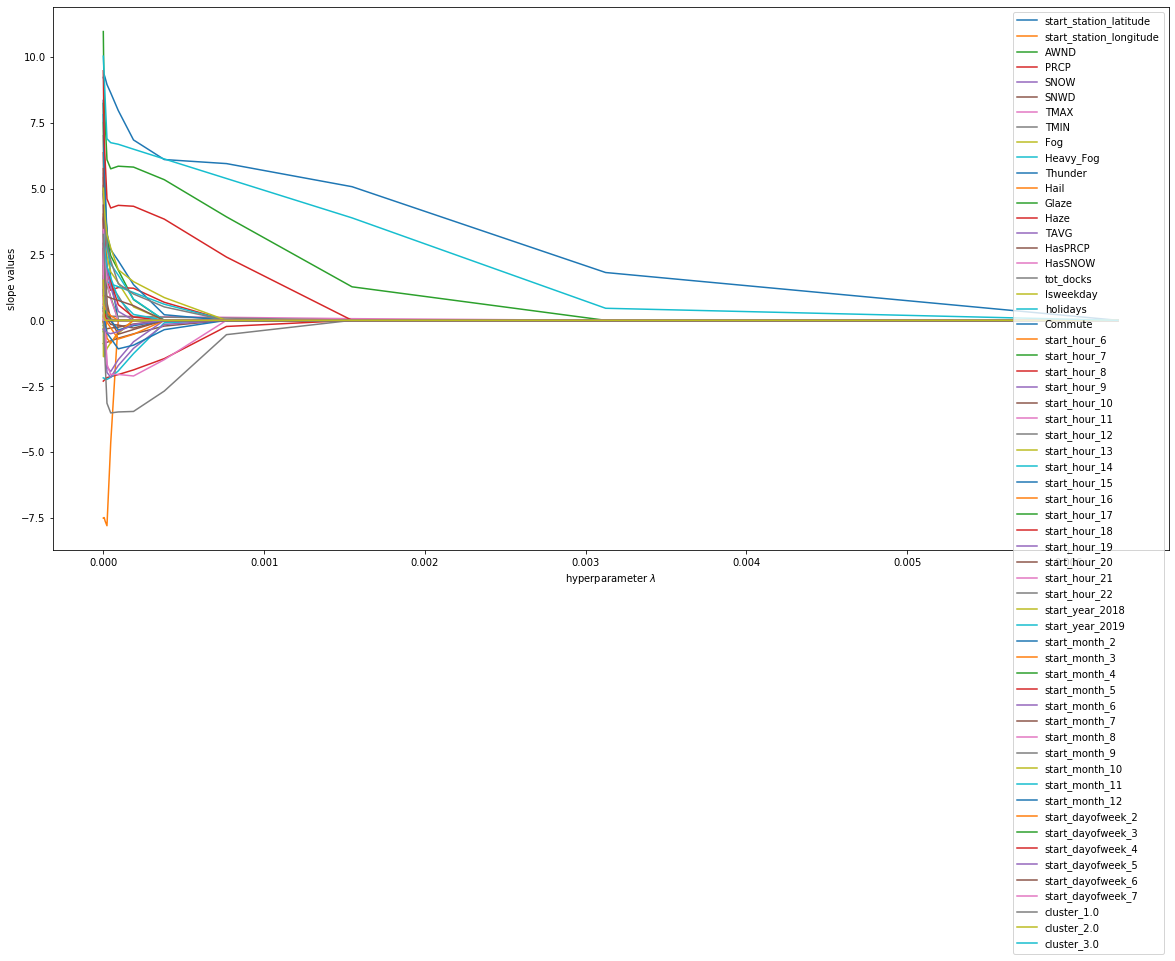

In [8]:
plt.figure(figsize=(20,10))
for name in coefs_df.columns:
    plt.plot(coefs_df.index, coefs_df[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)   

In [9]:
### find the alpha where coefficient becomes zero ###
alpha_zero = {}
for col in coefs_df.columns:
    for alpha in coefs_df.index:
        if coefs_df.loc[alpha, col] == 0:
            alpha_zero[col] = alpha
            break
alpha_zero = sorted(alpha_zero.items(), key=lambda x: x[1], reverse=True)
alpha_zero

[('Commute', 0.00630957344480193),
 ('cluster_3.0', 0.00630957344480193),
 ('TMAX', 0.0031241857136026677),
 ('tot_docks', 0.0031241857136026677),
 ('start_hour_17', 0.0031241857136026677),
 ('PRCP', 0.0015469407652461986),
 ('start_hour_18', 0.0015469407652461986),
 ('start_hour_22', 0.0015469407652461986),
 ('HasPRCP', 0.0007659678234751839),
 ('holidays', 0.0007659678234751839),
 ('start_hour_8', 0.0007659678234751839),
 ('start_hour_15', 0.0007659678234751839),
 ('start_hour_19', 0.0007659678234751839),
 ('start_hour_21', 0.0007659678234751839),
 ('start_year_2019', 0.0007659678234751839),
 ('start_month_2', 0.0007659678234751839),
 ('start_month_9', 0.0007659678234751839),
 ('start_month_10', 0.0007659678234751839),
 ('SNWD', 0.00037926901907322537),
 ('start_hour_7', 0.00037926901907322537),
 ('start_hour_9', 0.00037926901907322537),
 ('start_hour_10', 0.00037926901907322537),
 ('start_hour_12', 0.00037926901907322537),
 ('start_hour_13', 0.00037926901907322537),
 ('start_hour_14

In [10]:
top_features = [item[0] for item in alpha_zero[:40]]

In [11]:
# using lasso selected features only
X_after_FS = X[top_features].values
# split the training data into 80% and 20%
X_train, X_test, y_train, y_test =train_test_split(X_after_FS, Y, train_size=0.8, test_size=0.2, random_state=42)

In [12]:
import sklearn.model_selection as ms
from statistics import mean 
alphas_lasso = np.logspace(-7.5, -6, 30) #-8,-6,20
lasso = Lasso(normalize=True,tol=0.01)

dic = {}
for alpha in alphas_lasso:
    lasso.set_params(alpha=alpha)
    rmse = np.sqrt(-ms.cross_val_score(lasso, X_train, y_train, 
                      scoring="neg_mean_squared_error",cv = 3))
    dic[alpha] = mean(rmse)

# rmse for different alpha
alpha_rmse = pd.DataFrame.from_dict(dic, orient='index', columns = ['RMSE']).reset_index()

Text(0, 0.5, 'RMSE')

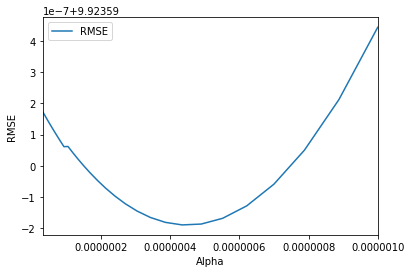

In [13]:
alpha_rmse.plot(x = "index", y = "RMSE")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [14]:
alpha_optimal = alpha_rmse.sort_values(by='RMSE').iloc[0,0]
alpha_optimal

4.3444122987293683e-07

In [15]:
lasso = Lasso(normalize=True,alpha = alpha_optimal)
%time lasso.fit(X_train,y_train)

Wall time: 6.38 s


Lasso(alpha=4.3444122987293683e-07, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
joblib.dump(lasso, 'lasso.jbl') 

['lasso.jbl']

In [17]:
print('Training score for train dataset is %.3f.' %(lasso.score(X_train,y_train)))
print('Testing score for train dataset is %.3f.' %(lasso.score(X_test,y_test)))

Training score for train dataset is 0.332.
Testing score for train dataset is 0.332.


### Lasso Performance on Orignal Test Dataset

In [18]:
lasso_saved = joblib.load('lasso.jbl') 

In [19]:
print('R2 score for the original test dataset using Lasso is %.3f. This is consistent with the train dataset performance.'\
      %(lasso_saved.score(test_X[top_features],test_Y)))

R2 score for the original test dataset using Lasso is 0.332. This is consistent with the train dataset performance.


## Tree Based Models

In [20]:
X = Top200.drop(['start_station_checkout_counts','Percent_usage','start_station_checkin_counts'],axis = 1)
Y = Top200.start_station_checkout_counts

In [21]:
test_X = Top200_test.drop(['start_station_checkout_counts','Percent_usage','start_station_checkin_counts'],axis = 1)
test_Y = Top200_test.start_station_checkout_counts

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

### XGBoost

In [23]:
xgb = XGBRegressor()
xgb.set_params(subsample=0.7,random_state=42, n_estimators=700,eta=0.12,max_depth = 8,verbose=1,n_jobs=6)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eta=0.12, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=8,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=6, num_parallel_tree=None,
             objective='reg:squarederror', random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=0.7,
             tree_method=None, validate_parameters=False, verbose=1,
             verbosity=None)

In [24]:
%time xgb.fit(X_train,y_train)

Wall time: 21min 48s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.12, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.119999997, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=6, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbose=1, verbosity=None)

In [25]:
print('Training score is %.3f' %(xgb.score(X_train,y_train)))
print('Testing score is %.3f' %(xgb.score(X_test,y_test))) #700, 0.12, max_depth=8

Training score is 0.818
Testing score is 0.773


In [26]:
#joblib.dump(xgb, 'xgb.jbl') 

In [27]:
sorted_importance_xgb = sorted(zip(X_train.columns.values, xgb.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_xgb

[('cluster', 0.29942653),
 ('Commute', 0.20857973),
 ('tot_docks', 0.05829298),
 ('TAVG', 0.052142713),
 ('start_hour', 0.048480768),
 ('start_station_latitude', 0.044043574),
 ('TMAX', 0.043605287),
 ('start_station_longitude', 0.03665962),
 ('start_dayofweek', 0.034858372),
 ('holidays', 0.029978035),
 ('PRCP', 0.023447115),
 ('start_year', 0.021407515),
 ('start_month', 0.019980138),
 ('TMIN', 0.013709813),
 ('Fog', 0.009398764),
 ('SNWD', 0.00908617),
 ('Thunder', 0.008697026),
 ('start_day', 0.008300351),
 ('AWND', 0.007622611),
 ('Haze', 0.0070855506),
 ('Heavy_Fog', 0.006075413),
 ('Glaze', 0.00457151),
 ('SNOW', 0.0045504584),
 ('Hail', 0.0),
 ('HasPRCP', 0.0),
 ('HasSNOW', 0.0),
 ('Isweekday', 0.0)]

Text(0.5, 1.0, 'Feature Importance Plot for XgBoost Model')

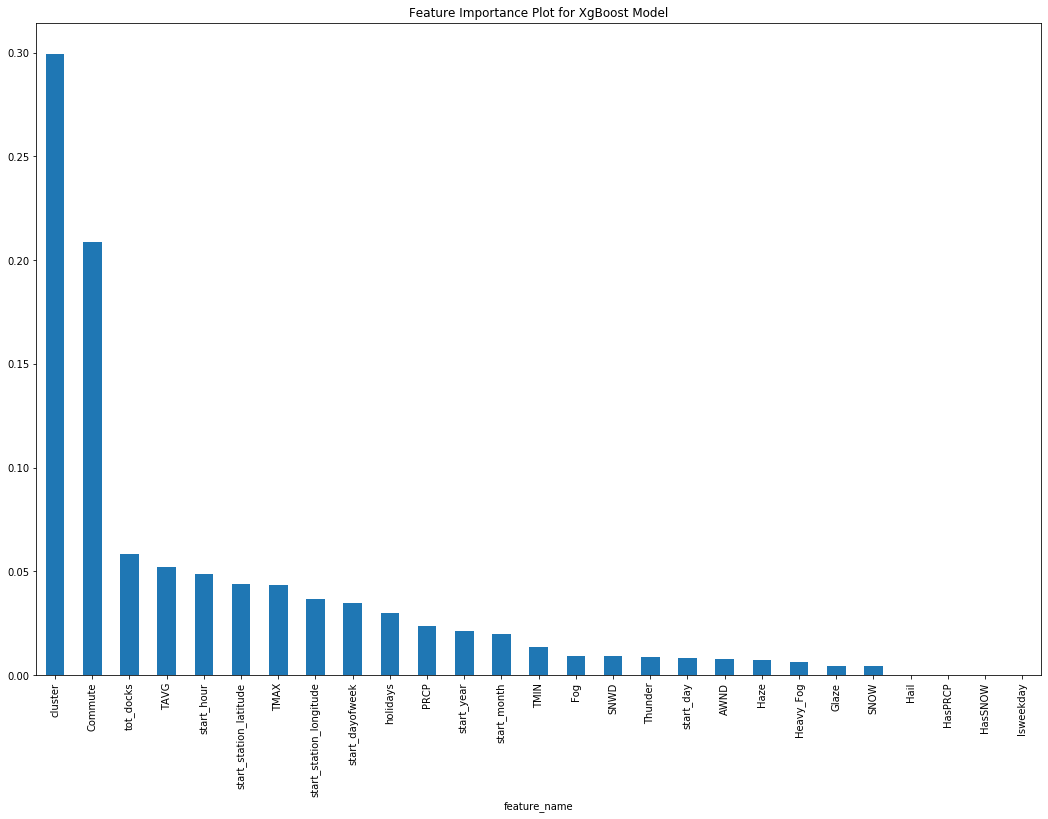

In [56]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_xgb) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot for XgBoost Model')

In [29]:
# grid_params = {'max_depth': range(4,8,3),
#                'eta':np.linspace(0.02,0.1,5)}
# grid_search_xgb = GridSearchCV(xgb, grid_params, cv = 3)
# %time grid_search_xgb.fit(X_train,y_train)

In [30]:
# grid_search_xgb.best_params_

In [31]:
# grid_search_xgb.score(X_train,y_train)

In [32]:
# grid_search_xgb.score(X_test,y_test)

### XGBoost Performance on Original Test Dataset

In [33]:
xgb_saved = joblib.load('xgb.jbl') 

In [34]:
print('R2 score for the original test dataset using XGBoost is %.3f. This is consistent with the train dataset performance.'\
      %(xgb_saved.score(test_X,test_Y)))

R2 score for the original test dataset using XGBoost is 0.800. This is consistent with the train dataset performance.


## Gradient Boosting

In [35]:
gbm = GradientBoostingRegressor()
gbm.set_params(learning_rate=0.03, n_estimators=1000, subsample=0.7, loss='ls', max_depth=4,\
               min_impurity_decrease=0.01,random_state = 42,verbose=1)
%time gbm.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1         143.9377           2.6722           62.82m
         2         142.9192           2.5946           62.11m
         3         139.4567           2.3852           62.08m
         4         137.9073           2.3248           61.87m
         5         135.0912           2.2077           61.71m
         6         133.6123           2.0570           61.72m
         7         131.4229           1.8947           61.73m
         8         128.9552           1.8830           61.61m
         9         127.4439           1.6859           61.59m
        10         125.7866           1.6701           61.52m
        20         112.6265           1.0252           60.89m
        30         104.9858           0.7934           60.26m
        40          99.8350           0.4755           59.53m
        50          95.0234           0.4165           58.97m
        60          92.3031           0.2831           58.37m
       

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.03, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [36]:
print('Training score is %.3f' %gbm.score(X_train,y_train))
print('Testing score is %.3f' %gbm.score(X_test,y_test))

Training score is 0.592
Testing score is 0.587


In [37]:
#joblib.dump(gbm, 'gbm.jbl') 

In [38]:
sorted_importance_gbm = sorted(zip(X_train.columns.values, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_gbm

[('Commute', 0.21381331083887248),
 ('start_hour', 0.18447505172582973),
 ('cluster', 0.17578983611631835),
 ('tot_docks', 0.09831682010161381),
 ('start_station_longitude', 0.06788351376523521),
 ('start_station_latitude', 0.06542765671690477),
 ('TMAX', 0.055854437042659896),
 ('TAVG', 0.05442652031854743),
 ('start_dayofweek', 0.022488202439492004),
 ('start_month', 0.013449346114952966),
 ('PRCP', 0.012791416554845423),
 ('Isweekday', 0.011905142271377213),
 ('TMIN', 0.010069259741643004),
 ('start_year', 0.006363288066507209),
 ('start_day', 0.0033721169751360957),
 ('holidays', 0.0015824953111767141),
 ('AWND', 0.000899288680303301),
 ('HasPRCP', 0.0005591040389281483),
 ('SNWD', 0.00017861416590652667),
 ('Fog', 0.00013740367452008838),
 ('Haze', 0.00011029794975500406),
 ('Thunder', 5.8281043263709794e-05),
 ('Heavy_Fog', 3.808744449854447e-05),
 ('SNOW', 1.0508474630213863e-05),
 ('HasSNOW', 4.2708224894526224e-10),
 ('Hail', 0.0),
 ('Glaze', 0.0)]

Text(0.5, 1.0, 'Feature Importance Plot for GBM model')

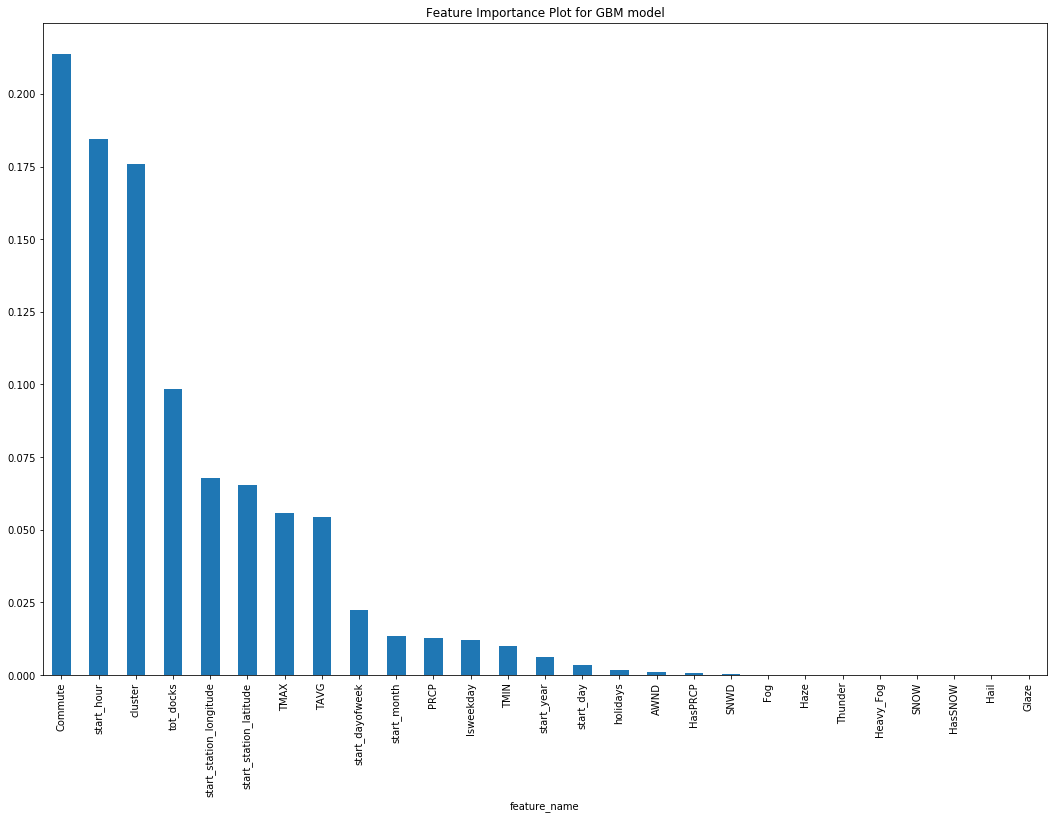

In [39]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_gbm) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
plt.title('Feature Importance Plot for GBM model')

In [40]:
# grid_params = {'max_depth': range(4,8,3),
#                'learning_rate':np.linspace(0.02,0.12,3),
#               "min_samples_split": np.linspace(start=5, stop=20, num=4, dtype=int)}
# grid_search_gbm = GridSearchCV(gbm, grid_params, cv = 3)
# %time grid_search_gbm.fit(X_train,y_train)

In [41]:
# grid_search_gbm.best_param_

### Performance on the Orginal Test Dataset 

In [42]:
gbm_saved =  joblib.load('gbm.jbl') 

In [43]:
print('R2 score for the original test dataset using GBM is %.3f. This is consistent with the train dataset performance.'\
      %(gbm_saved.score(test_X,test_Y)))

R2 score for the original test dataset using GBM is 0.592. This is consistent with the train dataset performance.


## Classification on Turnover Rate

## Random Forest

In [44]:
# Define a binary classifier High_turnover. 
# Threshold is set at 0.49, which is the median Percent Usage for all stations in the training dataset
Top200['High_turnover']=[1 if x>0.49 else 0 for x in Top200['Percent_usage']]
Top200_test['High_turnover'] = [1 if x>0.49 else 0 for x in Top200_test['Percent_usage']]

In [45]:
columns_to_drop = ['High_turnover', 'Percent_usage', 'start_station_checkout_counts', 'start_station_checkin_counts']
X_class = Top200.drop(columns_to_drop,axis = 1)
Y_class = Top200.High_turnover
test_X_class = Top200_test.drop(columns_to_drop,axis = 1)
test_Y_class = Top200_test.High_turnover

In [46]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, Y_class, train_size=0.8, test_size=0.2, random_state=42)

In [47]:
randomForest = RandomForestClassifier()

In [48]:
randomForest.set_params(random_state=42, max_features=4,max_depth = 12, n_estimators=2000,n_jobs=6)
%time randomForest.fit(X_train_class, y_train_class)  

Wall time: 18min 48s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=6, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
print('RandomForest train test score is %.3f' %(randomForest.score(X_train_class, y_train_class)))
print('RandomForest test test score is %.3f' %(randomForest.score(X_test_class, y_test_class)))

RandomForest train test score is 0.795
RandomForest test test score is 0.790


In [50]:
# joblib.dump(randomForest, 'randomForest.jbl') 

In [51]:
feature_importance = list(zip(X_train_class.columns, randomForest.feature_importances_))
feature_importance

[('start_station_latitude', 0.050019014228658405),
 ('start_station_longitude', 0.04541591996090587),
 ('start_hour', 0.16285627878890155),
 ('start_year', 0.006365490744015255),
 ('start_month', 0.04325516929015035),
 ('start_day', 0.006953334547190676),
 ('start_dayofweek', 0.013477261046433545),
 ('AWND', 0.01168614162692448),
 ('PRCP', 0.019779964179893257),
 ('SNOW', 0.002009414160343416),
 ('SNWD', 0.0031940228198886664),
 ('TMAX', 0.07600662632712221),
 ('TMIN', 0.06855465181277448),
 ('Fog', 0.00421240318017929),
 ('Heavy_Fog', 0.000490901592941433),
 ('Thunder', 0.0005593183581589149),
 ('Hail', 3.064691334418989e-05),
 ('Glaze', 0.00012553906738089094),
 ('Haze', 0.0009996550219501135),
 ('TAVG', 0.08862843159333453),
 ('HasPRCP', 0.0058494557311900945),
 ('HasSNOW', 0.0014451733047971852),
 ('tot_docks', 0.06463245632814975),
 ('Isweekday', 0.009756811529338966),
 ('holidays', 0.002888971864070623),
 ('Commute', 0.23698151260667122),
 ('cluster', 0.07382543337529048)]

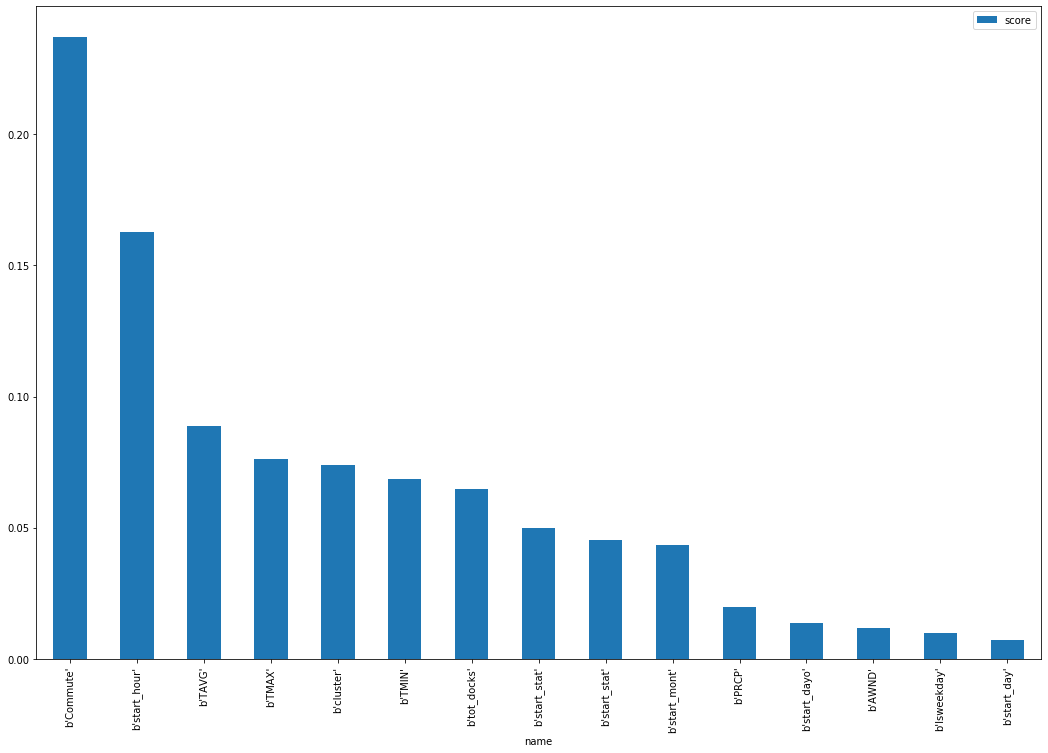

In [52]:
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [53]:
# grid_params = {'max_features':np,linspace(2,6,3),
#                'n_estimators':np.linspace(800,1200,5)}
# grid_search_randomForest = GridSearchCV(randomForest, grid_params, cv = 5)
# %time grid_search_randomForest.fit(X_train_class,y_train_class)

### Performance on the Orginal Test Dataset 

In [54]:
randomForest_saved = joblib.load('randomForest.jbl')

In [55]:
print('Classification accuracy for the original test dataset using RandomForest is %.3f'\
      %(randomForest_saved.score(test_X_class,test_Y_class)))
print('This is consistent with the train dataset performance.')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    9.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   39.8s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2000 out of 2000 | elapsed:  1.7min finished


Classification accuracy for the original test dataset using RandomForest is 0.792
This is consistent with the train dataset performance.
